# IoT - Reconhecimento de Atividade Humana com Deep Learning a partir de dados de acelerômetro do smartphone

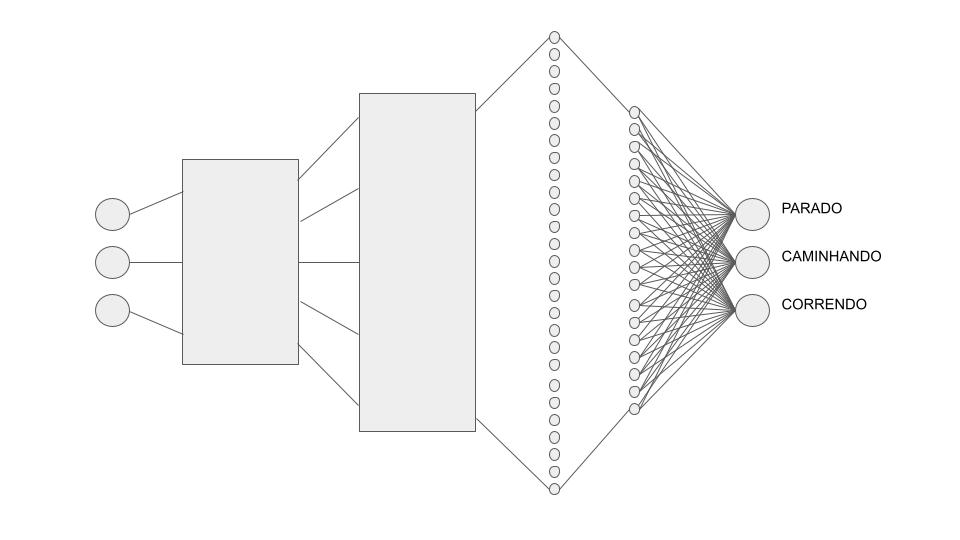

In [74]:
import tensorflow as tf
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
def LerArquivo(path):
    file = open(path)
    Arquivo = file.readlines()
    ConjuntoDeDados = []
    for i, linha in enumerate(Arquivo):
        linha = linha.split(',')
        ultimo = linha[4].split(';')[0]
        ultimo = ultimo.strip()
        if ultimo == '':
            break;
        temp = [linha[0], linha[1], linha[2], linha[3], ultimo]
        ConjuntoDeDados.append(temp)
    return ConjuntoDeDados

def CriarDataFrame(colunas, ConjuntoDeDados):
    data = pd.DataFrame(data = ConjuntoDeDados, columns = colunas)
    data['x'] = data['x'].astype('float')
    data['y'] = data['y'].astype('float')
    data['z'] = data['z'].astype('float') 
    return data

def Plotar_Eixos(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

def Plotar_Atividade(Atividade, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    Plotar_Eixos(ax0, data['Tempo'], data['x'], 'X-Axis')
    Plotar_Eixos(ax1, data['Tempo'], data['y'], 'Y-Axis')
    Plotar_Eixos(ax2, data['Tempo'], data['z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(Atividade)
    plt.subplots_adjust(top=0.90)
    plt.show()

def PlotarAtividadesEixos(Atividades, data):
    for Atividade in Atividades:
        data_for_plot = data[(data['Atividade'] == Atividade)][:Fs*5]
        Plotar_Atividade(Atividade, data_for_plot)

def CriarLabels(data):
    FrameDeDados = data.drop(['Tempo'], axis = 1).copy() 
    label = LabelEncoder()
    FrameDeDados['Atividade'] = label.fit_transform(FrameDeDados['Atividade']) 
    return FrameDeDados, label

def NormalizarEntrada(FrameDeDados):
    Entrada = FrameDeDados[['x', 'y', 'z']] 
    Saída = FrameDeDados['Atividade'] 
    scaler = StandardScaler()
    Entrada = scaler.fit_transform(Entrada) 
    Entrada_Normalizada = pd.DataFrame(data = Entrada, columns = ['x', 'y', 'z']) 
    Entrada_Normalizada['Atividade'] = Saída.values 
    return Entrada_Normalizada

def get_frames(df, frame_size, hop_size):
    N_FEATURES = 3
    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        label = stats.mode(df['Atividade'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES) #!!!!!!!!!!!!!
    labels = np.asarray(labels)
    return frames, labels

def CriarTreinamento(IN,OUT,TAMANHO_CONJ_TESTE):
    IN_Treino, IN_Teste, OUT_Treino, OUT_Teste = train_test_split(IN, OUT, test_size = TAMANHO_CONJ_TESTE, random_state = 0, stratify = OUT)
    IN_Treino = IN_Treino.reshape(IN_Treino.shape[0], IN_Treino.shape[1], IN_Treino.shape[2], 1) # Numpy array de formato (11456, 80, 3, 1)
    IN_Teste = IN_Teste.reshape(IN_Teste.shape[0], IN_Teste.shape[1], IN_Teste.shape[2], 1) # Numpy array de formato (2864, 80, 3, 1)
    IN_Treino[0].shape
    return IN_Treino, IN_Teste, OUT_Treino, OUT_Teste

def PlotarCurvaDeAprendizado(history, epochs):
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.title('Acurácia do Modelo')
    plt.ylabel('Acurácia')
    plt.xlabel('Épocas')
    plt.show()

def PlotarMatrizConfusao(IN_Teste, OUT_Teste):
    predict_x = model.predict(IN_Teste) 
    y_pred = np.argmax(predict_x,axis=1)
    mat = confusion_matrix(OUT_Teste, y_pred)
    plot_confusion_matrix(conf_mat=mat, show_normed=True, figsize=(4,4))

def ClassificarDados(caminho, model, index):
    ConjuntoDeDados = LerArquivo(caminho)
    Fs = 40
    colunas = ['Atividade', 'Tempo', 'x', 'y', 'z']
    data = CriarDataFrame(colunas,ConjuntoDeDados)
    #FrameDeDados, label = CriarLabels(data)
    Entrada_Normalizada = NormalizarEntrada(data)
    IN, OUT = get_frames(Entrada_Normalizada, frame_size, hop_size) #frames e labels
    IN_Treino, IN_Teste, OUT_Treino, OUT_Teste = CriarTreinamento(IN,OUT,0.2)
    prediction = model.predict(IN) 
    prediction = np.argmax(prediction[index])
    if prediction == 0:
        return "CAMINHANDO"
    else: 
        if prediction == 1:
            return "CORRENDO"
        else:
            return "PARADO"

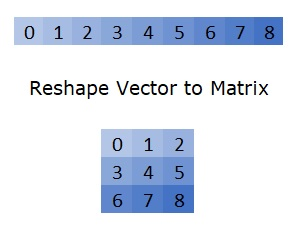

#MODELO 1

In [124]:
def CriarRedeNeural(IN_Treino):
    model = Sequential()
    model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = IN_Treino[0].shape))
    model.add(Dropout(0.1))
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

#MODELO 2

In [115]:
def CriarRedeNeural(IN_Treino):
    model = Sequential()    
    model.add(Conv2D(8, (2, 2), activation = 'relu', input_shape = IN_Treino[0].shape))
    #model.add(Dropout(0.1))
    model.add(Conv2D(8, (2, 2), activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(4, activation = 'sigmoid'))
    #model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [103]:
pd.read_csv('https://raw.githubusercontent.com/mateusxdz/Projeto_HAR_TopicoAvancado/main/dataset_Projeto.csv')

,caminhando,3.306197044E0,8.711249352E0,-4.558749676E0,3.026249886E0
0,caminhando,3.331197,8.216249,-4.44500,3.843750
1,caminhando,3.356197,7.212500,-4.96750,3.148750
2,caminhando,3.381197,6.143750,-3.95000,1.993750
3,caminhando,3.406197,6.015000,-3.03125,1.577500
4,caminhando,3.431197,5.871250,-3.29000,1.886250
...,...,...,...,...,...
14394,parado,122.558464,-0.003750,0.18250,9.933750
14395,parado,122.583464,-0.011250,0.12500,9.983749
14396,parado,122.608464,0.046250,0.19625,9.876249
14397,parado,122.633464,-0.025000,0.22500,9.876249


# phyphox -- PARADO

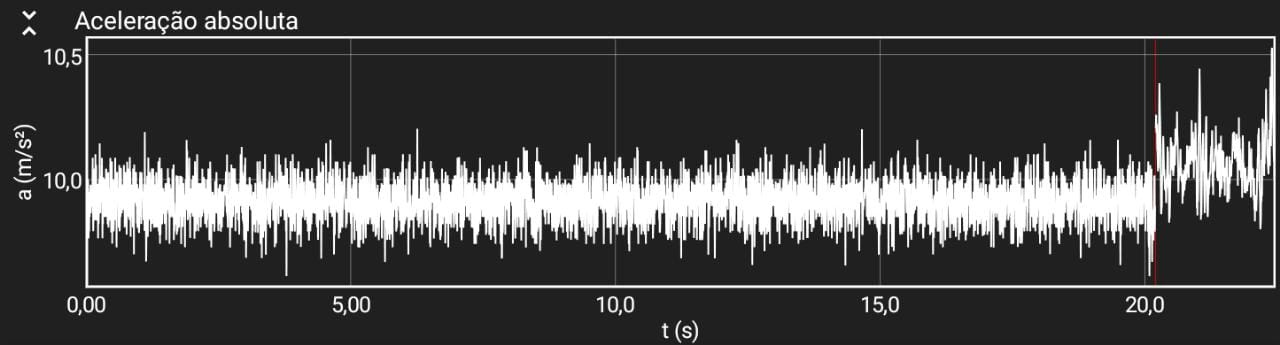

#phyphox -- CORRENDO

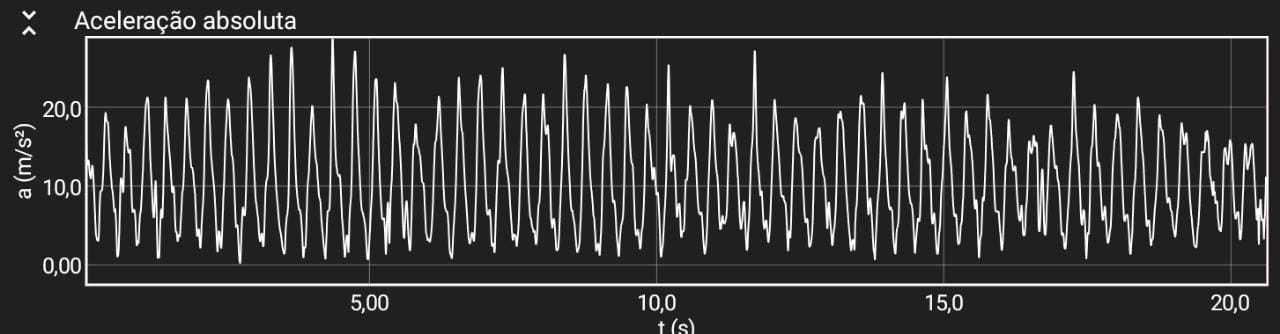

#phyphox -- CAMINHANDO

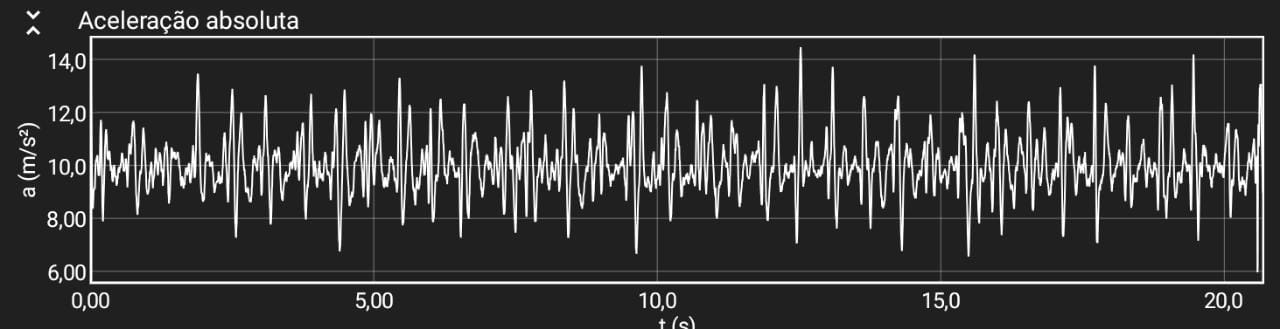

#EXECUÇÃO

In [125]:
ConjuntoDeDados = LerArquivo('/content/drive/MyDrive/ProjetoTopicosAvancados/dataset_Projeto.csv')

Fs = 40
colunas = ['Atividade', 'Tempo', 'x', 'y', 'z']

data = CriarDataFrame(colunas,ConjuntoDeDados)
Atividades = data['Atividade'].value_counts().index

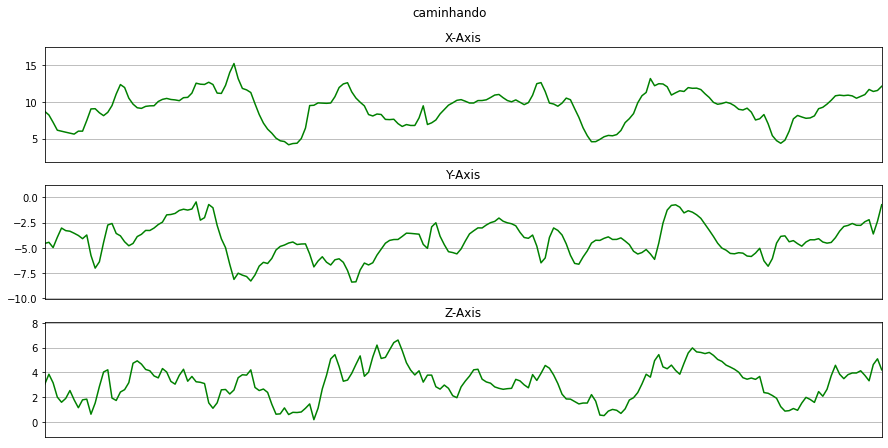

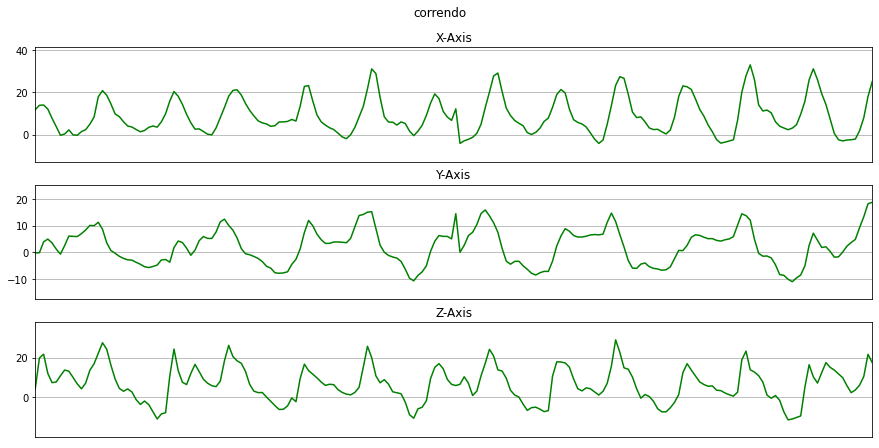

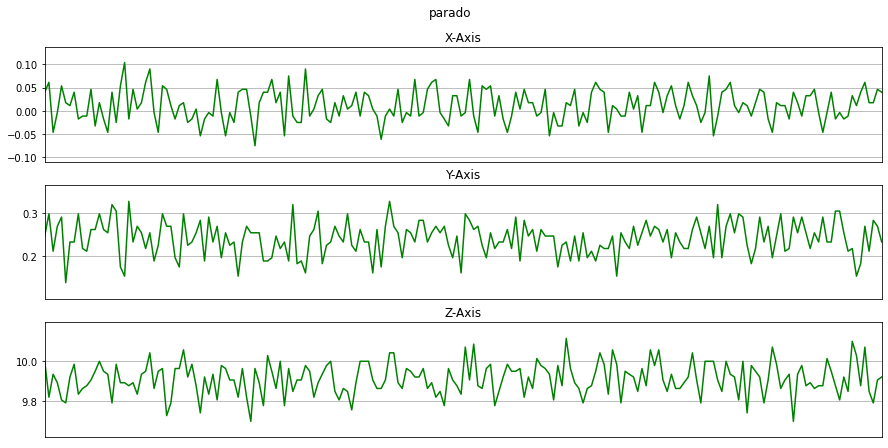

In [123]:
PlotarAtividadesEixos(Atividades, data)

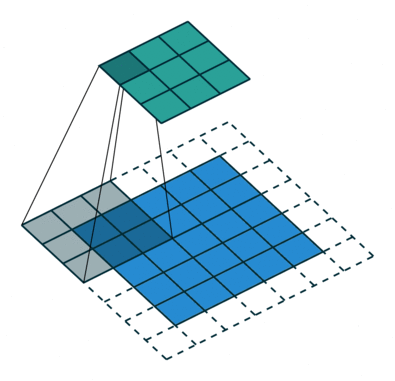

In [126]:
FrameDeDados, label = CriarLabels(data)
Entrada_Normalizada = NormalizarEntrada(FrameDeDados)

frame_size = Fs*4 #160
hop_size = Fs*2 #80  #!!!!!!!!!!!!!!!

IN, OUT = get_frames(Entrada_Normalizada, frame_size, hop_size) #frames e labels
IN_Treino, IN_Teste, OUT_Treino, OUT_Teste = CriarTreinamento(IN,OUT,0.2)
model = CriarRedeNeural(IN_Treino)

#TREINAMENTO

In [127]:
Épocas = 3
História = model.fit(IN_Treino, OUT_Treino, epochs = Épocas, validation_data= (IN_Teste, OUT_Teste), verbose = 0)

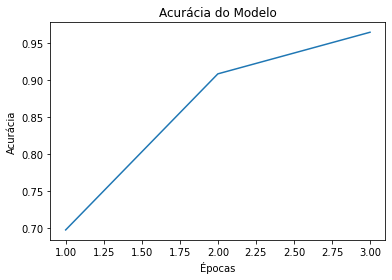

In [128]:
PlotarCurvaDeAprendizado(História, Épocas)

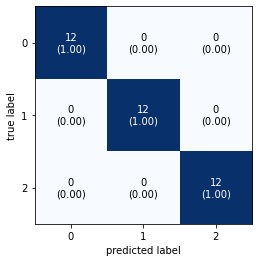

In [129]:
PlotarMatrizConfusao(IN_Teste, OUT_Teste)

In [121]:
i = 0
arquivo = '/content/drive/MyDrive/ProjetoTopicosAvancados/dataset_Projeto_teste.csv'

while (i < 178):
    print(str(ClassificarDados(arquivo, model, i)))
    i += 1

CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
CAMINHANDO
CAMINHANDO
PARADO
PARADO
PARADO
CAMINHANDO
PARADO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
PARADO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
PAR

In [122]:
IN

array([[[ 0.42835239,  0.34090483,  0.1635806 ],
        [-0.02522665, -0.04797183, -0.07336699],
        [-0.09743716, -0.11907822, -0.04797183],
        ...,
        [-0.36053849, -0.16439789,  0.01907073],
        [ 0.10915219,  0.03780327,  0.028437  ],
        [ 0.00777612,  0.028437  , -0.0236284 ]],

       [[ 0.35238794,  0.2344662 ,  0.22938719],
        [ 0.23822023,  0.13310651,  0.06465002],
        [ 0.11036125,  0.08872019,  0.08872019],
        ...,
        [-0.94840943, -0.66080995, -0.47899424],
        [-0.55970942, -0.55970942, -0.48836051],
        [-0.2781705 , -0.15503162, -0.13905382]],

       [[ 0.59816858,  0.61605553,  0.64763383],
        [ 0.61980972,  0.56283625,  0.47781781],
        [ 0.46015156,  0.50453788,  0.40936141],
        ...,
        [-0.44593681, -0.54703739, -0.53436541],
        [-0.47899424, -0.46466935, -0.64180198],
        [-0.81425145, -0.66080995, -0.64510769]],

       ...,

       [[-1.11125486, -1.1075008 , -1.10242177],
        [-1

In [114]:
i = 0
arquivo = '/content/drive/MyDrive/ProjetoTopicosAvancados/TESTE.csv'

while (i < 28):
    print(str(ClassificarDados(arquivo, model, i)))
    i += 1

CAMINHANDO
CAMINHANDO
CORRENDO
CORRENDO
CORRENDO
PARADO
PARADO
CORRENDO
CAMINHANDO
CORRENDO
PARADO
PARADO
CORRENDO
CORRENDO
CORRENDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
CAMINHANDO
PARADO
PARADO
PARADO
PARADO
PARADO
PARADO
